In [1]:
import pandas as pd
import numpy as np
import glob

import os
import tensorflow as tf   
from sklearn.preprocessing import scale
from tensorflow.keras.models import Model
from tensorflow.keras import layers, losses

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [3]:
tf.__version__

'2.0.1'

In [4]:
tf.test.is_gpu_available()

True

In [5]:
a = 6378137
e = 8.1819190842622e-2
asq = np.power(a,2)
esq = np.power(e,2)
def ecef2lla(ecef):
    x = ecef[0]
    y = ecef[1]
    z = ecef[2]
    r = ecef[3]
    b = np.sqrt( asq * (1-esq) )
    bsq = np.power(b,2)
    ep = np.sqrt( (asq - bsq)/bsq)
    p = np.sqrt(np.power(x,2) + np.power(y,2) )
    th = np.arctan2(a*z, b*p)
    lon = np.arctan2(y,x)
    lat = np.arctan2( (z + np.power(ep,2)*b*np.power(np.sin(th),3) ), (p - esq*a*np.power(np.cos(th),3)) )
    N = a/( np.sqrt(1-esq*np.power(np.sin(lat),2)) )
    alt = p / np.cos(lat) - N
    lon = lon % (2*np.pi)
    ret = [lat, lon, alt , r]
    return ret

In [6]:
datas = glob.glob('transfer/*/*/*.txt')
train_data = []
train_label = [] 
for data in datas:
    if data.find('timestamp') == -1:
        f = np.loadtxt(data,delimiter=" ").copy()
        if f.size == 4:
            f = f.reshape((1,-1))
        o = np.argsort(f,axis=(0))[:,3]
        f = np.array([ecef2lla(d) for d in f])
        f = f/np.array([(2*np.pi),(2*np.pi),1e+8,1e+14])
        f = f[o]
        f.resize((10,4))
        train_data.append(f) #/100000000
        if data.split('/')[1] == "indoor":
            train_label.append("indoor"+data.split('/')[-2])
        else:
            train_label.append("outdoor"+data.split('/')[-2])
        

train_data = np.array(train_data).astype('float32')
#train_data[:,:,0] -= train_data[:,:,0].mean()
#train_data[:,:,0] /= train_data[:,:,0].var()

#train_data[:,:,1] -= train_data[:,:,1].mean()
#train_data[:,:,1] /= train_data[:,:,1].var()
#train_data[:,:,2] -= train_data[:,:,2].mean()
#train_data[:,:,2] /= train_data[:,:,2].var()
#train_data[:,:,3] -= train_data[:,:,3].mean()
#train_data[:,:,3] /= 1000000
#train_label = pd.get_dummies(train_label).values.argmax(1)
#train_label = train_label.reshape(len(train_label),1)
train_label = np.array(pd.get_dummies(train_label)).astype('float32')

train_val_split = np.random.rand(len(train_data)) < 0.70
train_x = train_data[train_val_split]
train_y = train_label[train_val_split]
val_x = train_data[~train_val_split]
val_y = train_label[~train_val_split]

In [7]:
#pd.get_dummies(train_label)

In [8]:
train_label[10]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)

In [9]:
train_data[:,:,0].mean(),train_data[:,:,0].var(),train_data[:,:,0].max(),train_data[:,:,0].min()

(0.024973173, 0.0050530783, 0.15684304, -0.14916982)

In [10]:
train_data[:,:,1].mean(),train_data[:,:,1].var(),train_data[:,:,1].max(),train_data[:,:,1].min()

(0.17398076, 0.024483193, 0.9873238, 0.0)

In [11]:
train_data[:,:,2].mean(),train_data[:,:,2].var(),train_data[:,:,2].max(),train_data[:,:,2].min()

(0.12767042, 0.009381889, 0.20791996, 0.0)

In [12]:
train_data[:,:,3].mean(),train_data[:,:,3].var(),train_data[:,:,3].max(),train_data[:,:,3].min()

(-0.0006215025, 0.00044229845, 8.975531e-07, -0.71392393)

In [13]:
train_data.mean(),train_data.var()

(0.08150072, 0.01499602)

In [14]:
train_x.shape,train_y.shape,len(val_x)#.shape

((14861, 10, 4), (14861, 50), 6443)

In [15]:
BUFFER_SIZE = train_x.shape[0]
BATCH_SIZE = train_x.shape[0]
train_dataset = tf.data.Dataset.from_tensor_slices((train_x,train_y))
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
valid_dataset = tf.data.Dataset.from_tensor_slices((val_x,val_y)).batch(len(val_x))

In [16]:
class DenseTranspose(tf.keras.layers.Layer):
    def __init__(self, dense, activation=None, **kwargs):
        self.dense = dense
        self.activation = tf.keras.activations.get(activation)
        super().__init__(**kwargs)
    def build(self, batch_input_shape):
        self.biases = self.add_weight(name='bias',shape=[self.dense.input_shape[-1]],initializer="zeros")
        super().build(batch_input_shape)
    def call(self, inputs):
        z = tf.matmul(inputs, self.dense.weights[0], transpose_b = True)
        return self.activation(z + self.biases)

In [17]:
#mirrored_strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0","/gpu:1"])
#with mirrored_strategy.scope():
input_o = tf.keras.layers.Input(shape=(4), name='input_layer')
dense1 = layers.Dense(4, activation='relu')
dense2 = layers.Dense(4, activation='relu')
dense3 = layers.Dense(4, activation='relu')
dense4 = layers.Dense(4, activation='relu')
models = dense1(input_o )
models = dense2(models)
models = dense3(models)
models = dense4(models)
model = tf.keras.Model(inputs=input_o, outputs=models)

input_oo = tf.keras.layers.Input(shape=(4), name='input_layer0')
models2 = DenseTranspose(dense4, activation = 'relu')(input_oo)
models2 = DenseTranspose(dense3, activation = 'relu')(models2)
models2 = DenseTranspose(dense2, activation = 'relu')(models2)
models2 = DenseTranspose(dense1, activation = 'relu')(models2)
model2 = tf.keras.Model(inputs=input_oo, outputs=models2)

input = tf.keras.layers.Input(shape=(10,4), name='input_layer1')
input1 = layers.Lambda(lambda x: x[:,0,:], output_shape=(1))(input)
input2 = layers.Lambda(lambda x: x[:,1,:], output_shape=(1))(input)
input3 = layers.Lambda(lambda x: x[:,2,:], output_shape=(1))(input)
input4 = layers.Lambda(lambda x: x[:,3,:], output_shape=(1))(input)
input5 = layers.Lambda(lambda x: x[:,4,:], output_shape=(1))(input)
input6 = layers.Lambda(lambda x: x[:,5,:], output_shape=(1))(input)
input7 = layers.Lambda(lambda x: x[:,6,:], output_shape=(1))(input)
input8 = layers.Lambda(lambda x: x[:,7,:], output_shape=(1))(input)
input9 = layers.Lambda(lambda x: x[:,8,:], output_shape=(1))(input)
input10= layers.Lambda(lambda x: x[:,9,:], output_shape=(1))(input)
model_1 = model(input1)
model_2 = model(input2)
model_3 = model(input3)
model_4 = model(input4)
model_5 = model(input5)
model_6 = model(input6)
model_7 = model(input7)
model_8 = model(input8)
model_9 = model(input9)
model_10= model(input10)
merge_layer = tf.keras.layers.concatenate(inputs=[model_1, model_2,model_3,model_4,model_5,model_6,model_7,model_8,model_9,model_10])
dense5 = layers.Dense(32, activation='relu')
dense6 = layers.Dense(24, activation='relu')
dense7 = layers.Dense(16, activation='relu')
model_encoder = dense5(merge_layer)
model_encoder = dense6(model_encoder)
model_encoder = dense7(model_encoder)
model_down = tf.keras.Model(inputs=[input], outputs=model_encoder,name = "encoder")#input1, input2,input3,input4,input5,input6,input7,input8,input9,input10


input_decoder = tf.keras.layers.Input(shape=(16), name='input_layer2')#model_down(input_encoder)
model_decoder = DenseTranspose(dense7, activation = 'relu')(input_decoder)
model_decoder = DenseTranspose(dense6, activation = 'relu')(model_decoder)
model_decoder = DenseTranspose(dense5, activation = 'relu')(model_decoder)
model_decoder = layers.Reshape((10,4))(model_decoder)
"""
out1 = layers.Lambda(lambda x: x[:,0,:], output_shape=(1))(model_decoder)
out2 = layers.Lambda(lambda x: x[:,1,:], output_shape=(1))(model_decoder)
out3 = layers.Lambda(lambda x: x[:,2,:], output_shape=(1))(model_decoder)
out4 = layers.Lambda(lambda x: x[:,3,:], output_shape=(1))(model_decoder)
out5 = layers.Lambda(lambda x: x[:,4,:], output_shape=(1))(model_decoder)
out6 = layers.Lambda(lambda x: x[:,5,:], output_shape=(1))(model_decoder)
out7 = layers.Lambda(lambda x: x[:,6,:], output_shape=(1))(model_decoder)
out8 = layers.Lambda(lambda x: x[:,7,:], output_shape=(1))(model_decoder)
out9 = layers.Lambda(lambda x: x[:,8,:], output_shape=(1))(model_decoder)
out10= layers.Lambda(lambda x: x[:,9,:], output_shape=(1))(model_decoder)
model_1 = model2(out1)
model_2 = model2(out2)
model_3 = model2(out3)
model_4 = model2(out4)
model_5 = model2(out5)
model_6 = model2(out6)
model_7 = model2(out7)
model_8 = model2(out8)
model_9 = model2(out9)
model_10= model2(out10)
merge_layer_out = tf.keras.layers.concatenate(inputs=[model_1, model_2,model_3,model_4,model_5,model_6,model_7,model_8,model_9,model_10])
merge_layer_out = layers.Reshape((10,4))(merge_layer_out)
"""
model_up = tf.keras.Model(inputs=[input_decoder], outputs=[model_decoder],name = "decoder")
#model_decoder2 = layers.Reshape((10,4))(merge_layer_out)

input_ann = tf.keras.layers.Input(shape=(16), name='input_layer3')
model_ann = tf.keras.layers.Dense(24, activation='relu')(input_ann)
model_ann = tf.keras.layers.Dropout(0.5, noise_shape=None, seed=None)(model_ann)
model_ann = tf.keras.layers.Dense(32, activation='relu')(model_ann)
model_ann = tf.keras.layers.Dropout(0.5, noise_shape=None, seed=None)(model_ann)
model_ann = tf.keras.layers.Dense(32, activation='relu')(model_ann)
model_ann = tf.keras.layers.Dropout(0.5, noise_shape=None, seed=None)(model_ann)
model_ann = tf.keras.layers.Dense(32, activation='relu')(model_ann)
model_ann = tf.keras.layers.Dense(50, activation='softmax')(model_ann)
model_ANN = tf.keras.Model(inputs=[input_ann], outputs=model_ann,name = "ann")


input_full = tf.keras.layers.Input(shape=(10,4), name='input_layer4')
encoder_out = model_down(input_full)
decoder_out = model_up(encoder_out)
ann_out = model_ANN(encoder_out)
model_encoder_decoder = tf.keras.Model(inputs=[input_full],outputs=[decoder_out,ann_out],name = 'encoder_decoder_ann')




#model_encoder_decoder.summary()
#optimizer = tf.keras.optimizers.SGD(learning_rate=1e-2, momentum=1e-5)
#model_encoder_decoder.compile(optimizer = 'sgd', loss=losses.MeanSquaredError())

In [18]:
shared_vars = model_encoder_decoder.trainable_variables[:14]
decode_vars = model_encoder_decoder.trainable_variables[14:17]
ann_vars = model_encoder_decoder.trainable_variables[17:]

In [19]:
len(model_encoder_decoder.trainable_variables)

27

In [20]:
for i in range(27):
    print(model_encoder_decoder.trainable_variables[i].shape)

(4, 4)
(4,)
(4, 4)
(4,)
(4, 4)
(4,)
(4, 4)
(4,)
(40, 32)
(32,)
(32, 24)
(24,)
(24, 16)
(16,)
(24,)
(32,)
(40,)
(16, 24)
(24,)
(24, 32)
(32,)
(32, 32)
(32,)
(32, 32)
(32,)
(32, 50)
(50,)


In [21]:
def model_loss(output,t_x,t_y):
    #print("in loss")
    output_AE , output_label = output
    #output_AE = output
    mse = losses.MeanSquaredError()
    AE_loss = mse(t_x,output_AE)
    ann_loss =losses.categorical_crossentropy(t_y,output_label)
    total_loss = AE_loss*100 + ann_loss
    
    return AE_loss,ann_loss

In [22]:
learning_rate_A = tf.keras.optimizers.schedules.ExponentialDecay(
initial_learning_rate=1e-2, decay_steps=100, decay_rate=0.9)
optimizer_A = tf.optimizers.SGD(learning_rate=learning_rate_A , momentum=1e-5)
learning_rate_B = tf.keras.optimizers.schedules.ExponentialDecay(
initial_learning_rate=1e-2, decay_steps=100, decay_rate=0.9)
optimizer_B = tf.optimizers.Adam(learning_rate=learning_rate_B)

In [23]:
def train_step(t_x,t_y):
  
    with tf.GradientTape() as AE_tape,tf.GradientTape() as ANN_tape:
        output = model_encoder_decoder(t_x, training=True)
        #AE_loss = model_loss(output,t_o,t_y)
        AE_loss,ANN_loss = model_loss(output,t_x,t_y)
        #gradients = tape.gradient(total_loss, shared_vars+decode_vars)
        #optimizer_A.apply_gradients(zip(gradients, shared_vars+decode_vars))

    if np.random.rand() < 0.5:
        #print("AE")
        gradients_AE = AE_tape.gradient(AE_loss, shared_vars+decode_vars)
        #gradients_AE = [tf.clip_by_value(g, -1,1) for g in gradients_AE]

        #print("AE gradient : ",gradients_AE)
        optimizer_A.apply_gradients(zip(gradients_AE, shared_vars+decode_vars))
    
    else:
        #print("ANN")
        gradients_ANN = ANN_tape.gradient(ANN_loss, shared_vars+ann_vars)
        #print("ANN gradient : ",gradients_ANN)
        #gradients_ANN = [tf.clip_by_value(g, -1,1) for g in gradients_ANN] 
        optimizer_B.apply_gradients(zip(gradients_ANN, shared_vars+ann_vars))
    
    return np.array(AE_loss).mean(),np.array(ANN_loss).mean()

In [24]:
checkpoint_dir = './gps_checkpoints/checkpoints_1222'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_1222_model_{epoch}")
checkpoint = tf.train.Checkpoint(optimizerA=optimizer_A,
                                 optimizerB=optimizer_B,
                                 model_encoder_decoder=model_encoder_decoder,
                                 model_down=model_down)

In [25]:
def validation(v_x,v_y):
    output = model_encoder_decoder(v_x)
    #output_AE = output
    output_AE , output_label = output
    mse = losses.MeanSquaredError()
    AE_loss = mse(v_x,output_AE)
    ann_loss = losses.categorical_crossentropy(v_y,output_label)
    total_loss = AE_loss*100 + ann_loss
    #print(output_label[200])
    #print(v_y[200])
    #print(ann_loss)
    #print("AE loss : {},".format(np.array(AE_loss).mean()))
    print("AE loss : {}, ANN loss : {}, Total loss : {}".format(np.array(AE_loss).mean(),np.array(ann_loss).mean(),np.array(total_loss).mean()))

In [26]:
import time
def train(epochs):
  for epoch in range(epochs):
    start = time.time()
    all_AE = []
    all_ANN =[]
    for x,y in train_dataset:
        #AE_loss = train_step(x,y)
        AE_loss,ANN_loss = train_step(x,y)
        all_AE.append(AE_loss)
        all_ANN.append(ANN_loss)
    #print("train AE loss : {}".format(np.array(all_AE).mean()))
    print("train AE loss : {}, train ANN loss : {}".format(np.array(all_AE).mean(),np.array(all_ANN).mean()))
    validation(val_x,val_y)
    checkpoint.save(file_prefix=checkpoint_prefix)
    print("learning rate A : ",optimizer_A._decayed_lr(tf.float32))
    print("learning rate B : ",optimizer_B._decayed_lr(tf.float32))
    print(f'Time for epoch {epoch + 1} is {time.time() - start:.4f} sec')

In [27]:
train(500)

train AE loss : 0.021512070670723915, train ANN loss : 3.9119906425476074
AE loss : 0.021644750609993935, ANN loss : 3.9120073318481445, Total loss : 6.076481819152832
learning rate A :  tf.Tensor(0.009989469, shape=(), dtype=float32)
learning rate B :  tf.Tensor(0.01, shape=(), dtype=float32)
Time for epoch 1 is 0.4966 sec
train AE loss : 0.02149840071797371, train ANN loss : 3.912012815475464
AE loss : 0.020776230841875076, ANN loss : 3.908710479736328, Total loss : 5.98633337020874
learning rate A :  tf.Tensor(0.009989469, shape=(), dtype=float32)
learning rate B :  tf.Tensor(0.009989469, shape=(), dtype=float32)
Time for epoch 2 is 0.2872 sec
train AE loss : 0.020631253719329834, train ANN loss : 3.908583879470825
AE loss : 0.020755525678396225, ANN loss : 3.9087088108062744, Total loss : 5.9842610359191895
learning rate A :  tf.Tensor(0.00997895, shape=(), dtype=float32)
learning rate B :  tf.Tensor(0.009989469, shape=(), dtype=float32)
Time for epoch 3 is 0.1828 sec
train AE loss

In [28]:
class PrintLR(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    print('\nLearning rate for epoch {} is {}'.format(epoch + 1,
                                                      model_encoder_decoder.optimizer.lr.numpy()))

In [29]:
val_latent = model_down(val_x)

In [30]:
val_latent

<tf.Tensor: id=627077, shape=(6443, 16), dtype=float32, numpy=
array([[0.00282131, 0.04940335, 0.        , ..., 0.        , 0.        ,
        0.04733327],
       [0.01026605, 0.06043176, 0.        , ..., 0.        , 0.        ,
        0.0680249 ],
       [0.00181532, 0.049019  , 0.        , ..., 0.        , 0.        ,
        0.05388596],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]], dtype=float32)>

In [31]:
from sklearn import manifold, datasets
import matplotlib.pyplot as plt

In [32]:
train_val_split = np.random.rand(len(val_latent)) < 0.4

In [33]:
X_tsne = manifold.TSNE(n_components=2, init='pca', n_iter=5000, method='exact').fit_transform(val_latent[train_val_split])

In [34]:
y = val_y[train_val_split].argmax(axis=1).reshape([-1,1])

In [35]:
X_tsne.shape

(2554, 2)

In [36]:
val_latent.shape

TensorShape([6443, 16])

In [37]:
 X_tsne.min(0)

array([-62.12664 , -50.942444], dtype=float32)

In [38]:
 X_tsne.max(0)

array([50.860874, 49.19238 ], dtype=float32)

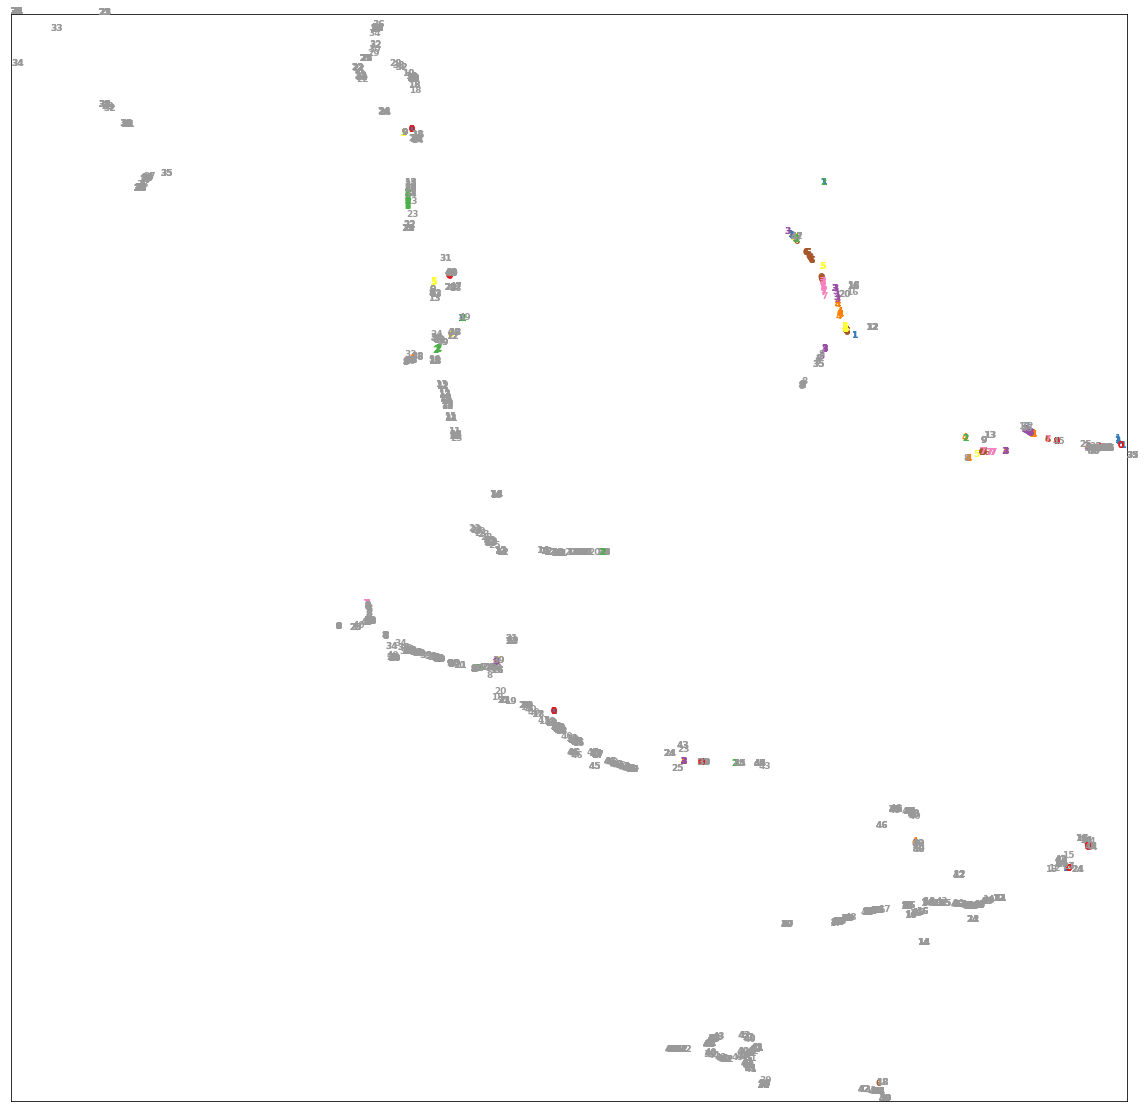

In [39]:
x_min, x_max = X_tsne.min(0), X_tsne.max(0)
X_norm = (X_tsne - x_min) / (x_max - x_min)
plt.figure(figsize=(20, 20))
for i in range(X_norm.shape[0]):
    plt.text(X_norm[i, 0], X_norm[i, 1], str(y[i,0]), color=plt.cm.Set1(y[i,0]), 
             fontdict={'weight': 'bold', 'size': 9})
plt.xticks([])
plt.yticks([])
plt.savefig("result/gps_pca_latent16")
plt.show()